In [1]:
#
# NOTE: This machine learning program is for predicting TC formation, using
#       input dataset in the NETCDF format. The program treats different
#       2D input fields as different channels of an image. This specific
#       program requires a set of 12 2D-variables (12-channel image) and
#       consists of three stages
#       - Stage 1: reading NETCDF input and generating (X,y) data with a
#                  given image sizes, which are then saved by pickle;
#       - Stage 2: import the saved pickle (X,y) pair and build a CNN model
#                  with a given training/validation ratio, and then save
#                  the train model under tcg_CNN.model.
#       - Stage 3: import the trained model from Stage 2, and make a list
#                  of prediction from normalized test data.
#
# INPUT: This Stage 2 script requires two specific input datasets that are
#        generated from Step 1, including
#        1. tcg_X.pickle: data contains all images of yes/no TCG events, each
#           of these images must have 12 channels
#        2. tcg_y.pickle: data contains all labels of each image (i.e., yes
#           or no) of TCG corresponding to each data in X.
#
#        Remarks: Note that each channel must be normalized separealy. Also
#        the script requires a large memory allocation. So users need to have
#        GPU version to run this.
#
# OUTPUT: A CNN model built from Keras saved under tcg_CNN.model
#
# HIST: - 27, Oct 22: Created by CK
#       - 01, Nov 22: Modified to include more channels
#       - 17, Nov 23: cusomize it for jupiter notebook
#       - 21, Feb 23: use functional model instead of sequential model  
#       - 05, Jun 23: Re-check for consistency with Stage 1 script and added more hyperparamter loops
#       - 20, Jun 23: Updated for augmentation/dropout layers
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu)
#
#==========================================================================
import tensorflow as tf
import numpy as np
import pickle
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

2023-06-20 13:57:40.783460: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#
# read in data output from Part 1
#
pickle_in = open("tcg_CNNaugment_X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("tcg_CNNaugment_y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)
number_channels=X.shape[3]
print('Input shape of the X features data: ',X.shape)
print('Input shape of the y label data: ',y.shape)
print('Number of input channel extracted from X is: ',number_channels)

Input shape of the X features data:  (704, 30, 30, 12)
Input shape of the y label data:  (704,)
Number of input channel extracted from X is:  12


In [3]:
#
# normalize the data before training the model
#
nsample = X.shape[0]
for i in range(nsample):
    for var in range(number_channels):    
        maxvalue = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('Normalization factor for sample and channel',i,var,', is: ',abs(maxvalue))
        X[i,:,:,var] = X[i,:,:,var]/abs(maxvalue)
        maxnew = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('-->After normalization of sample and channel',i,var,', is: ',abs(maxnew))
        #input('Enter to continue...')
print("Finish normalization...")

Finish normalization...


In [4]:
#
# build a range of CNN models with different number of dense layer, layer sizes, and
# convolution layers to optimize the performance
#
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)])
dense_layers = [0, 1, 2]
layer_sizes = [32]
conv_layers = [3, 5]
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-layer-{}-dense.model_00h".format(conv_layer, layer_size, dense_layer)
            print('--> Running configuration: ',NAME)

            inputs = keras.Input(shape=X.shape[1:])      
            x = data_augmentation(inputs)
            x = layers.Conv2D(filters=layer_size,kernel_size=conv_layer,activation="relu",name="my_conv2d_1")(x)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_1")(x)
            x = layers.Conv2D(filters=layer_size*2,kernel_size=conv_layer,activation="relu",name="my_conv2d_2")(x)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_2")(x)
            if conv_layer == 3:
                x = layers.Conv2D(filters=layer_size*4,kernel_size=conv_layer,activation="relu",name="my_conv2d_3")(x)
                x = layers.MaxPooling2D(pool_size=2,name="my_pooling_3")(x)

            if X.shape[1] > 128:
                x = layers.Conv2D(filters=256,kernel_size=conv_layer,activation="relu",name="my_conv2d_4")(x)
                x = layers.MaxPooling2D(pool_size=2,name="my_pooling_4")(x)
                x = layers.Conv2D(filters=256,kernel_size=conv_layer,activation="relu",name="my_conv2d_5")(x)
            x = layers.Flatten(name="my_flatten")(x)
            x = layers.Dropout(0.2)(x)
            
            for _ in range(dense_layer):
                x = layers.Dense(layer_size,activation="relu")(x)                
                
            outputs = layers.Dense(1,activation="sigmoid",name="my_dense")(x)
            model = keras.Model(inputs=inputs,outputs=outputs,name="my_functional_model")
            model.summary()
            keras.utils.plot_model(model)
            
            callbacks=[keras.callbacks.ModelCheckpoint(NAME,save_best_only=True)]
            model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
            history = model.fit(X, y, batch_size=128, epochs=30, validation_split=0.1, callbacks=callbacks)

2023-06-20 13:58:50.023596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 13:58:53.615387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:b1:00.0, compute capability: 7.0


--> Running configuration:  3-conv-32-layer-0-dense.model_00h
Model: "my_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 sequential (Sequential)     (None, 30, 30, 12)        0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 12, 12, 64)        18496     
                                                                 
 my_pooling_2 (MaxPooling2D)  (None, 6, 6, 64)         0         
                                                   

2023-06-20 13:59:02.184070: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


5/5 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.6461

INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 18s 551ms/step - loss: 0.6495 - accuracy: 0.6461 - val_loss: 0.5413 - val_accuracy: 0.8169
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.8847

INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 481ms/step - loss: 0.4414 - accuracy: 0.8847 - val_loss: 0.2828 - val_accuracy: 0.9437
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.9084

INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 432ms/step - loss: 0.2584 - accuracy: 0.9084 - val_loss: 0.1917 - val_accuracy: 0.9437
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9131

INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 431ms/step - loss: 0.2021 - accuracy: 0.9131 - val_loss: 0.1603 - val_accuracy: 0.9437
Epoch 5/30
5/5 [==============================] - 0s 73ms/step - loss: 0.1889 - accuracy: 0.9179 - val_loss: 0.1653 - val_accuracy: 0.9296
Epoch 6/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1499 - accuracy: 0.9352 - val_loss: 0.2331 - val_accuracy: 0.9155
Epoch 7/30
5/5 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9321

INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 507ms/step - loss: 0.1745 - accuracy: 0.9321 - val_loss: 0.1428 - val_accuracy: 0.9437
Epoch 8/30
5/5 [==============================] - 0s 72ms/step - loss: 0.1568 - accuracy: 0.9415 - val_loss: 0.2531 - val_accuracy: 0.9014
Epoch 9/30
5/5 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9510

INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 434ms/step - loss: 0.1268 - accuracy: 0.9510 - val_loss: 0.1267 - val_accuracy: 0.9577
Epoch 10/30
5/5 [==============================] - 0s 76ms/step - loss: 0.1393 - accuracy: 0.9510 - val_loss: 0.1751 - val_accuracy: 0.9155
Epoch 11/30
5/5 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9494

INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 504ms/step - loss: 0.1129 - accuracy: 0.9494 - val_loss: 0.1086 - val_accuracy: 0.9718
Epoch 12/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1047 - accuracy: 0.9589 - val_loss: 0.1632 - val_accuracy: 0.9296
Epoch 13/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0975 - accuracy: 0.9716 - val_loss: 0.1097 - val_accuracy: 0.9437
Epoch 14/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0956 - accuracy: 0.9621 - val_loss: 0.1226 - val_accuracy: 0.9437
Epoch 15/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0950 - accuracy: 0.9573 - val_loss: 0.1415 - val_accuracy: 0.9296
Epoch 16/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0829 - accuracy: 0.9700 - val_loss: 0.1149 - val_accuracy: 0.9437
Epoch 17/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0660 - accuracy: 0.9747 - val_loss: 0.1356 - val_accuracy: 0.9437
Epoch 18/30
5/5 [==============

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 3s 451ms/step - loss: 0.5802 - accuracy: 0.7567 - val_loss: 0.3790 - val_accuracy: 0.9296
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8942

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 489ms/step - loss: 0.3132 - accuracy: 0.8942 - val_loss: 0.2097 - val_accuracy: 0.9014
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9084

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 424ms/step - loss: 0.2259 - accuracy: 0.9084 - val_loss: 0.1944 - val_accuracy: 0.9155
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9052

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 403ms/step - loss: 0.2081 - accuracy: 0.9052 - val_loss: 0.1852 - val_accuracy: 0.9296
Epoch 5/30
5/5 [==============================] - 0s 75ms/step - loss: 0.1784 - accuracy: 0.9226 - val_loss: 0.3074 - val_accuracy: 0.8873
Epoch 6/30
5/5 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9305

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 500ms/step - loss: 0.1551 - accuracy: 0.9305 - val_loss: 0.1526 - val_accuracy: 0.9296
Epoch 7/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1442 - accuracy: 0.9400 - val_loss: 0.1923 - val_accuracy: 0.9296
Epoch 8/30
5/5 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9431

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 417ms/step - loss: 0.1378 - accuracy: 0.9431 - val_loss: 0.1415 - val_accuracy: 0.9296
Epoch 9/30
5/5 [==============================] - 0s 72ms/step - loss: 0.1241 - accuracy: 0.9558 - val_loss: 0.1593 - val_accuracy: 0.9437
Epoch 10/30
5/5 [==============================] - 0s 72ms/step - loss: 0.1134 - accuracy: 0.9494 - val_loss: 0.1431 - val_accuracy: 0.9296
Epoch 11/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1025 - accuracy: 0.9573 - val_loss: 0.1437 - val_accuracy: 0.9437
Epoch 12/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0963 - accuracy: 0.9605 - val_loss: 0.1470 - val_accuracy: 0.9437
Epoch 13/30
5/5 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9605

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 408ms/step - loss: 0.1034 - accuracy: 0.9605 - val_loss: 0.1241 - val_accuracy: 0.9437
Epoch 14/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0773 - accuracy: 0.9684 - val_loss: 0.1395 - val_accuracy: 0.9437
Epoch 15/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0800 - accuracy: 0.9684 - val_loss: 0.1457 - val_accuracy: 0.9437
Epoch 16/30
5/5 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9684

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 551ms/step - loss: 0.0711 - accuracy: 0.9684 - val_loss: 0.1165 - val_accuracy: 0.9437
Epoch 17/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0824 - accuracy: 0.9716 - val_loss: 0.1320 - val_accuracy: 0.9577
Epoch 18/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0762 - accuracy: 0.9668 - val_loss: 0.1380 - val_accuracy: 0.9577
Epoch 19/30
5/5 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9763

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 408ms/step - loss: 0.0604 - accuracy: 0.9763 - val_loss: 0.1062 - val_accuracy: 0.9437
Epoch 20/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0699 - accuracy: 0.9684 - val_loss: 0.1580 - val_accuracy: 0.9577
Epoch 21/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0693 - accuracy: 0.9763 - val_loss: 0.1069 - val_accuracy: 0.9296
Epoch 22/30
5/5 [==============================] - 0s 71ms/step - loss: 0.0582 - accuracy: 0.9795 - val_loss: 0.1355 - val_accuracy: 0.9577
Epoch 23/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0488 - accuracy: 0.9826 - val_loss: 0.1068 - val_accuracy: 0.9577
Epoch 24/30
5/5 [==============================] - 0s 72ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 0.1315 - val_accuracy: 0.9577
Epoch 25/30
5/5 [==============================] - 0s 72ms/step - loss: 0.0502 - accuracy: 0.9810 - val_loss: 0.1159 - val_accuracy: 0.9577
Epoch 26/30
5/5 [==============

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 402ms/step - loss: 0.0347 - accuracy: 0.9921 - val_loss: 0.1032 - val_accuracy: 0.9577
Epoch 29/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0433 - accuracy: 0.9842 - val_loss: 0.1200 - val_accuracy: 0.9577
Epoch 30/30
5/5 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9842

INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-0-dense.model_00h/assets


5/5 [==============================] - 2s 497ms/step - loss: 0.0472 - accuracy: 0.9842 - val_loss: 0.0937 - val_accuracy: 0.9577
--> Running configuration:  3-conv-32-layer-1-dense.model_00h
Model: "my_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 sequential (Sequential)     (None, 30, 30, 12)        0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 12, 12, 64)        18496     
                                                      

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 3s 476ms/step - loss: 0.6591 - accuracy: 0.5671 - val_loss: 0.5608 - val_accuracy: 0.8873
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.5180 - accuracy: 0.8120

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 537ms/step - loss: 0.5180 - accuracy: 0.8120 - val_loss: 0.4160 - val_accuracy: 0.8592
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8452

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 453ms/step - loss: 0.3870 - accuracy: 0.8452 - val_loss: 0.2366 - val_accuracy: 0.9155
Epoch 4/30
5/5 [==============================] - 0s 73ms/step - loss: 0.3022 - accuracy: 0.8736 - val_loss: 0.2954 - val_accuracy: 0.8732
Epoch 5/30
5/5 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9036

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 453ms/step - loss: 0.2438 - accuracy: 0.9036 - val_loss: 0.1944 - val_accuracy: 0.9014
Epoch 6/30
5/5 [==============================] - 0s 73ms/step - loss: 0.2271 - accuracy: 0.9100 - val_loss: 0.2140 - val_accuracy: 0.9155
Epoch 7/30
5/5 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9226

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 534ms/step - loss: 0.1848 - accuracy: 0.9226 - val_loss: 0.1809 - val_accuracy: 0.9296
Epoch 8/30
5/5 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9352

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 453ms/step - loss: 0.1686 - accuracy: 0.9352 - val_loss: 0.1661 - val_accuracy: 0.9296
Epoch 9/30
5/5 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9479

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 453ms/step - loss: 0.1457 - accuracy: 0.9479 - val_loss: 0.1545 - val_accuracy: 0.9155
Epoch 10/30
5/5 [==============================] - 0s 76ms/step - loss: 0.1463 - accuracy: 0.9368 - val_loss: 0.1726 - val_accuracy: 0.9296
Epoch 11/30
5/5 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9510

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 539ms/step - loss: 0.1180 - accuracy: 0.9510 - val_loss: 0.1179 - val_accuracy: 0.9296
Epoch 12/30
5/5 [==============================] - 0s 76ms/step - loss: 0.1117 - accuracy: 0.9526 - val_loss: 0.1295 - val_accuracy: 0.9437
Epoch 13/30
5/5 [==============================] - 0s 73ms/step - loss: 0.1033 - accuracy: 0.9637 - val_loss: 0.1201 - val_accuracy: 0.9437
Epoch 14/30
5/5 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9652

INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 451ms/step - loss: 0.0847 - accuracy: 0.9652 - val_loss: 0.0957 - val_accuracy: 0.9437
Epoch 15/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0885 - accuracy: 0.9668 - val_loss: 0.1096 - val_accuracy: 0.9437
Epoch 16/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0713 - accuracy: 0.9700 - val_loss: 0.1145 - val_accuracy: 0.9437
Epoch 17/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0691 - accuracy: 0.9731 - val_loss: 0.1686 - val_accuracy: 0.9437
Epoch 18/30
5/5 [==============================] - 0s 77ms/step - loss: 0.0710 - accuracy: 0.9684 - val_loss: 0.1232 - val_accuracy: 0.9577
Epoch 19/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0570 - accuracy: 0.9810 - val_loss: 0.1171 - val_accuracy: 0.9577
Epoch 20/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0552 - accuracy: 0.9763 - val_loss: 0.0981 - val_accuracy: 0.9577
Epoch 21/30
5/5 [==============

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 3s 533ms/step - loss: 0.6184 - accuracy: 0.6746 - val_loss: 0.4309 - val_accuracy: 0.8592
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.8910

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 441ms/step - loss: 0.3207 - accuracy: 0.8910 - val_loss: 0.2215 - val_accuracy: 0.9155
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9115

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 502ms/step - loss: 0.2231 - accuracy: 0.9115 - val_loss: 0.2070 - val_accuracy: 0.9296
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9179

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 439ms/step - loss: 0.2022 - accuracy: 0.9179 - val_loss: 0.2014 - val_accuracy: 0.9014
Epoch 5/30
5/5 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9336

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 425ms/step - loss: 0.1734 - accuracy: 0.9336 - val_loss: 0.1531 - val_accuracy: 0.9296
Epoch 6/30
5/5 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9336

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 512ms/step - loss: 0.1453 - accuracy: 0.9336 - val_loss: 0.1440 - val_accuracy: 0.9296
Epoch 7/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1300 - accuracy: 0.9558 - val_loss: 0.1533 - val_accuracy: 0.9296
Epoch 8/30
5/5 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9510

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 434ms/step - loss: 0.1228 - accuracy: 0.9510 - val_loss: 0.1360 - val_accuracy: 0.9437
Epoch 9/30
5/5 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9479

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 415ms/step - loss: 0.1093 - accuracy: 0.9479 - val_loss: 0.1199 - val_accuracy: 0.9155
Epoch 10/30
5/5 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9652

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 515ms/step - loss: 0.0922 - accuracy: 0.9652 - val_loss: 0.0989 - val_accuracy: 0.9437
Epoch 11/30
5/5 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9605

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 422ms/step - loss: 0.1072 - accuracy: 0.9605 - val_loss: 0.0879 - val_accuracy: 0.9718
Epoch 12/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0821 - accuracy: 0.9684 - val_loss: 0.0920 - val_accuracy: 0.9577
Epoch 13/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0819 - accuracy: 0.9684 - val_loss: 0.1239 - val_accuracy: 0.9437
Epoch 14/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0790 - accuracy: 0.9684 - val_loss: 0.1571 - val_accuracy: 0.9437
Epoch 15/30
5/5 [==============================] - 0s 72ms/step - loss: 0.1172 - accuracy: 0.9542 - val_loss: 0.0985 - val_accuracy: 0.9577
Epoch 16/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0955 - accuracy: 0.9605 - val_loss: 0.1291 - val_accuracy: 0.9577
Epoch 17/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0907 - accuracy: 0.9684 - val_loss: 0.0997 - val_accuracy: 0.9577
Epoch 18/30
5/5 [==============

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 429ms/step - loss: 0.0644 - accuracy: 0.9716 - val_loss: 0.0853 - val_accuracy: 0.9577
Epoch 21/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0571 - accuracy: 0.9795 - val_loss: 0.1174 - val_accuracy: 0.9577
Epoch 22/30
5/5 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9842

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 518ms/step - loss: 0.0515 - accuracy: 0.9842 - val_loss: 0.0792 - val_accuracy: 0.9718
Epoch 23/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0681 - accuracy: 0.9731 - val_loss: 0.1494 - val_accuracy: 0.9577
Epoch 24/30
5/5 [==============================] - 0s 72ms/step - loss: 0.0443 - accuracy: 0.9889 - val_loss: 0.0799 - val_accuracy: 0.9577
Epoch 25/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0462 - accuracy: 0.9795 - val_loss: 0.0910 - val_accuracy: 0.9577
Epoch 26/30
5/5 [==============================] - 0s 72ms/step - loss: 0.0534 - accuracy: 0.9826 - val_loss: 0.1323 - val_accuracy: 0.9577
Epoch 27/30
5/5 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9779

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 444ms/step - loss: 0.0689 - accuracy: 0.9779 - val_loss: 0.0768 - val_accuracy: 0.9577
Epoch 28/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0532 - accuracy: 0.9826 - val_loss: 0.1743 - val_accuracy: 0.9296
Epoch 29/30
5/5 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9826

INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-1-dense.model_00h/assets


5/5 [==============================] - 2s 509ms/step - loss: 0.0681 - accuracy: 0.9826 - val_loss: 0.0612 - val_accuracy: 0.9437
Epoch 30/30
5/5 [==============================] - 0s 72ms/step - loss: 0.0404 - accuracy: 0.9889 - val_loss: 0.1141 - val_accuracy: 0.9577
--> Running configuration:  3-conv-32-layer-2-dense.model_00h
Model: "my_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 sequential (Sequential)     (None, 30, 30, 12)        0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                              

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 3s 496ms/step - loss: 0.6536 - accuracy: 0.6572 - val_loss: 0.5357 - val_accuracy: 0.8451
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.4424 - accuracy: 0.8831

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 555ms/step - loss: 0.4424 - accuracy: 0.8831 - val_loss: 0.3393 - val_accuracy: 0.8451
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8768

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 471ms/step - loss: 0.2678 - accuracy: 0.8768 - val_loss: 0.2544 - val_accuracy: 0.9155
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9036

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 471ms/step - loss: 0.2135 - accuracy: 0.9036 - val_loss: 0.2085 - val_accuracy: 0.9296
Epoch 5/30
5/5 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9163

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 561ms/step - loss: 0.2113 - accuracy: 0.9163 - val_loss: 0.1662 - val_accuracy: 0.9155
Epoch 6/30
5/5 [==============================] - 0s 74ms/step - loss: 0.2397 - accuracy: 0.8957 - val_loss: 0.4044 - val_accuracy: 0.8310
Epoch 7/30
5/5 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9068

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 466ms/step - loss: 0.2328 - accuracy: 0.9068 - val_loss: 0.1584 - val_accuracy: 0.9296
Epoch 8/30
5/5 [==============================] - 0s 73ms/step - loss: 0.1910 - accuracy: 0.9242 - val_loss: 0.2015 - val_accuracy: 0.9155
Epoch 9/30
5/5 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9321

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 537ms/step - loss: 0.1863 - accuracy: 0.9321 - val_loss: 0.1513 - val_accuracy: 0.9155
Epoch 10/30
5/5 [==============================] - 0s 73ms/step - loss: 0.1487 - accuracy: 0.9400 - val_loss: 0.1762 - val_accuracy: 0.9296
Epoch 11/30
5/5 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9558

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 475ms/step - loss: 0.1235 - accuracy: 0.9558 - val_loss: 0.1245 - val_accuracy: 0.9296
Epoch 12/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1127 - accuracy: 0.9589 - val_loss: 0.1625 - val_accuracy: 0.9155
Epoch 13/30
5/5 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9542

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 534ms/step - loss: 0.1136 - accuracy: 0.9542 - val_loss: 0.1191 - val_accuracy: 0.9437
Epoch 14/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0964 - accuracy: 0.9573 - val_loss: 0.1647 - val_accuracy: 0.9155
Epoch 15/30
5/5 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9637

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 486ms/step - loss: 0.0938 - accuracy: 0.9637 - val_loss: 0.1100 - val_accuracy: 0.9437
Epoch 16/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0717 - accuracy: 0.9731 - val_loss: 0.1684 - val_accuracy: 0.9155
Epoch 17/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0810 - accuracy: 0.9652 - val_loss: 0.1121 - val_accuracy: 0.9437
Epoch 18/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0768 - accuracy: 0.9716 - val_loss: 0.1798 - val_accuracy: 0.9296
Epoch 19/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0688 - accuracy: 0.9795 - val_loss: 0.1206 - val_accuracy: 0.9437
Epoch 20/30
5/5 [==============================] - 0s 72ms/step - loss: 0.0662 - accuracy: 0.9747 - val_loss: 0.1330 - val_accuracy: 0.9437
Epoch 21/30
5/5 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9858

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 474ms/step - loss: 0.0394 - accuracy: 0.9858 - val_loss: 0.1073 - val_accuracy: 0.9437
Epoch 22/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0628 - accuracy: 0.9763 - val_loss: 0.1181 - val_accuracy: 0.9437
Epoch 23/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0546 - accuracy: 0.9810 - val_loss: 0.1205 - val_accuracy: 0.9437
Epoch 24/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0375 - accuracy: 0.9874 - val_loss: 0.1163 - val_accuracy: 0.9437
Epoch 25/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0446 - accuracy: 0.9874 - val_loss: 0.1286 - val_accuracy: 0.9437
Epoch 26/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0403 - accuracy: 0.9842 - val_loss: 0.1093 - val_accuracy: 0.9437
Epoch 27/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0595 - accuracy: 0.9810 - val_loss: 0.1101 - val_accuracy: 0.9437
Epoch 28/30
5/5 [==============

INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 3-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 572ms/step - loss: 0.0296 - accuracy: 0.9889 - val_loss: 0.1024 - val_accuracy: 0.9437
--> Running configuration:  5-conv-32-layer-2-dense.model_00h
Model: "my_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 sequential (Sequential)     (None, 30, 30, 12)        0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 26, 26, 32)        9632      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 13, 13, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 9, 9, 64)          51264     
                                                      

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 3s 547ms/step - loss: 0.6384 - accuracy: 0.6825 - val_loss: 0.4719 - val_accuracy: 0.8169
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8894

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 447ms/step - loss: 0.3845 - accuracy: 0.8894 - val_loss: 0.2243 - val_accuracy: 0.9296
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.8989

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 447ms/step - loss: 0.2489 - accuracy: 0.8989 - val_loss: 0.1675 - val_accuracy: 0.9155
Epoch 4/30
5/5 [==============================] - 0s 73ms/step - loss: 0.1985 - accuracy: 0.9210 - val_loss: 0.2016 - val_accuracy: 0.9014
Epoch 5/30
5/5 [==============================] - 0s 75ms/step - loss: 0.2066 - accuracy: 0.9131 - val_loss: 0.1837 - val_accuracy: 0.9437
Epoch 6/30
5/5 [==============================] - 0s 76ms/step - loss: 0.1779 - accuracy: 0.9305 - val_loss: 0.1823 - val_accuracy: 0.9014
Epoch 7/30
5/5 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9384

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 543ms/step - loss: 0.1462 - accuracy: 0.9384 - val_loss: 0.1282 - val_accuracy: 0.9437
Epoch 8/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1348 - accuracy: 0.9558 - val_loss: 0.1503 - val_accuracy: 0.9437
Epoch 9/30
5/5 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9510

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 446ms/step - loss: 0.1255 - accuracy: 0.9510 - val_loss: 0.1046 - val_accuracy: 0.9577
Epoch 10/30
5/5 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9573

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 446ms/step - loss: 0.1023 - accuracy: 0.9573 - val_loss: 0.0978 - val_accuracy: 0.9577
Epoch 11/30
5/5 [==============================] - 0s 74ms/step - loss: 0.1210 - accuracy: 0.9494 - val_loss: 0.1185 - val_accuracy: 0.9437
Epoch 12/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0930 - accuracy: 0.9731 - val_loss: 0.1106 - val_accuracy: 0.9577
Epoch 13/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0823 - accuracy: 0.9652 - val_loss: 0.0996 - val_accuracy: 0.9577
Epoch 14/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0852 - accuracy: 0.9684 - val_loss: 0.1378 - val_accuracy: 0.9437
Epoch 15/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0790 - accuracy: 0.9684 - val_loss: 0.1071 - val_accuracy: 0.9437
Epoch 16/30
5/5 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9763

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 526ms/step - loss: 0.0671 - accuracy: 0.9763 - val_loss: 0.0939 - val_accuracy: 0.9437
Epoch 17/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0730 - accuracy: 0.9795 - val_loss: 0.1057 - val_accuracy: 0.9577
Epoch 18/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0631 - accuracy: 0.9810 - val_loss: 0.0960 - val_accuracy: 0.9437
Epoch 19/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0691 - accuracy: 0.9763 - val_loss: 0.0972 - val_accuracy: 0.9437
Epoch 20/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0491 - accuracy: 0.9810 - val_loss: 0.1143 - val_accuracy: 0.9577
Epoch 21/30
5/5 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9842

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 445ms/step - loss: 0.0503 - accuracy: 0.9842 - val_loss: 0.0910 - val_accuracy: 0.9437
Epoch 22/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0518 - accuracy: 0.9795 - val_loss: 0.0977 - val_accuracy: 0.9437
Epoch 23/30
5/5 [==============================] - 0s 76ms/step - loss: 0.0528 - accuracy: 0.9747 - val_loss: 0.1544 - val_accuracy: 0.9437
Epoch 24/30
5/5 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9810

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 531ms/step - loss: 0.0493 - accuracy: 0.9810 - val_loss: 0.0852 - val_accuracy: 0.9437
Epoch 25/30
5/5 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9826

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 454ms/step - loss: 0.0455 - accuracy: 0.9826 - val_loss: 0.0785 - val_accuracy: 0.9718
Epoch 26/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0557 - accuracy: 0.9795 - val_loss: 0.0967 - val_accuracy: 0.9577
Epoch 27/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0430 - accuracy: 0.9779 - val_loss: 0.1352 - val_accuracy: 0.9437
Epoch 28/30
5/5 [==============================] - 0s 73ms/step - loss: 0.0393 - accuracy: 0.9858 - val_loss: 0.0798 - val_accuracy: 0.9859
Epoch 29/30
5/5 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9731

INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


INFO:tensorflow:Assets written to: 5-conv-32-layer-2-dense.model_00h/assets


5/5 [==============================] - 2s 437ms/step - loss: 0.0593 - accuracy: 0.9731 - val_loss: 0.0713 - val_accuracy: 0.9577
Epoch 30/30
5/5 [==============================] - 0s 75ms/step - loss: 0.0883 - accuracy: 0.9605 - val_loss: 0.1550 - val_accuracy: 0.9437


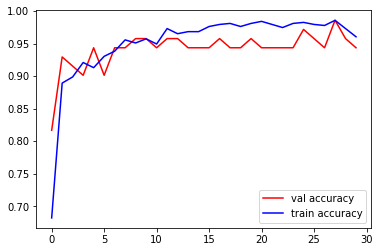

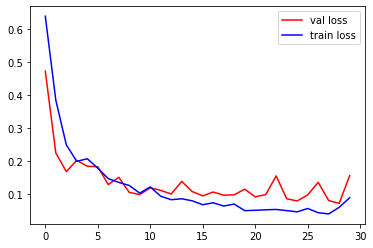

In [6]:
#
# Visualize the output of the training model (work for jupyter notebook only)
#
import matplotlib.pyplot as plt
check_visualization = "yes"
if check_visualization== "yes":
    #print(history.__dict__)
    #print(history.history)
    val_accuracy = history.history['val_accuracy']
    accuracy = history.history['accuracy']
    epochs = history.epoch 
    plt.plot(epochs,val_accuracy,'r',label="val accuracy")
    plt.plot(epochs,accuracy,'b',label="train accuracy")
    plt.legend()

    plt.figure()
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    plt.plot(epochs,val_loss,'r',label="val loss")
    plt.plot(epochs,loss,'b',label="train loss")
    plt.legend()
    plt.show()